In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
df = pd.read_csv('../data/insurance_data_clean.csv',low_memory=False)

In [38]:

# ---------------------------
# GENDER-BASED RISK ANALYSIS
# ---------------------------
df_gendered = df[df["Gender"].isin(["Male", "Female"])].copy()

df_gendered["HasClaim"] = (df_gendered["TotalClaims"].fillna(0) > 0).astype(int)

# Claim Frequency: count of claims / total per gender
gender_counts = df_gendered.groupby("Gender")["PolicyID"].count()
claims_by_gender = df_gendered.groupby("Gender")["HasClaim"].sum()

count = np.array([claims_by_gender.get("Male", 0), claims_by_gender.get("Female", 0)])
nobs = np.array([gender_counts.get("Male", 0), gender_counts.get("Female", 0)])

# Proportion Z-test
from statsmodels.stats.proportion import proportions_ztest
z_stat, p_freq = proportions_ztest(count, nobs)

# Claim Severity: only among those who had a claim
df_claims = df_gendered[df_gendered["HasClaim"] == 1]

male_severity = df_claims[df_claims["Gender"] == "Male"]["TotalClaims"].dropna()
female_severity = df_claims[df_claims["Gender"] == "Female"]["TotalClaims"].dropna()

from scipy.stats import ttest_ind
t_stat, p_severity = ttest_ind(male_severity, female_severity, equal_var=False)
count =np.array([claims_by_gender['Male'], claims_by_gender['Female']])
nobs = np.array([gender_counts['Male'], gender_counts["Female"]])
z_stat, p_freq = proportions_ztest(count, nobs)

print("=== Gender-Based Risk Analysis ===\n")

print(f"Claim Frequency:")
print(f"Male: {count[0]}/{nobs[0]} = {count[0]/nobs[0]:.2%}")
print(f"Female: {count[1]}/{nobs[1]} = {count[1]/nobs[1]:.2%}")
print(f"Z-test p-value: {p_freq:.5f}")
print("→" , "Reject H₀" if p_freq < 0.05 else "Fail to reject H₀")

print("\nClaim Severity (given a claim occurred):")
print(f"Male mean: {male_severity.mean():,.2f}")
print(f"Female mean: {female_severity.mean():,.2f}")
print(f"T-test p-value: {p_severity:.5f}")
print("→" , "Reject H₀" if p_severity < 0.05 else "Fail to reject H₀")

=== Gender-Based Risk Analysis ===

Claim Frequency:
Male: 94/42817 = 0.22%
Female: 14/6755 = 0.21%
Z-test p-value: 0.84049
→ Fail to reject H₀

Claim Severity (given a claim occurred):
Male mean: 14,858.55
Female mean: 17,874.72
T-test p-value: 0.56803
→ Fail to reject H₀


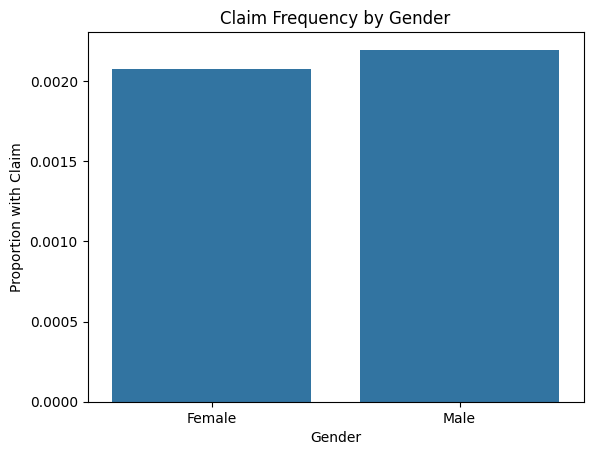

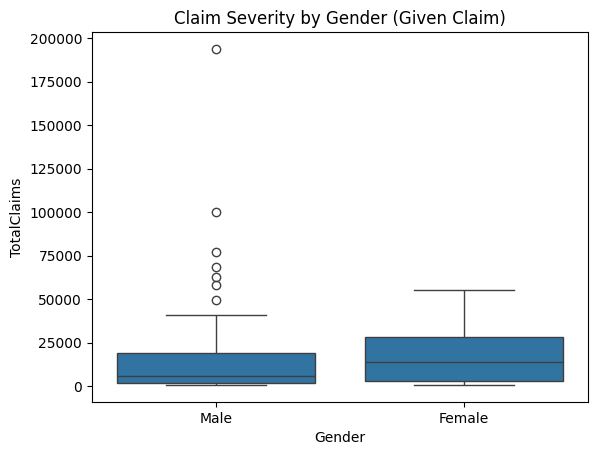

In [7]:
# Claim Frequency Plot
sns.barplot(x=gender_counts.index, y=claims_by_gender / gender_counts)
plt.title("Claim Frequency by Gender")
plt.ylabel("Proportion with Claim")
plt.show()

# Severity Boxplot
sns.boxplot(x="Gender", y="TotalClaims", data=df_claims)
plt.title("Claim Severity by Gender (Given Claim)")
plt.show()

Null Hypothesis (H₀): There are no risk differences across provinces.
ANOVA F-statistic: 0.9022
p-value: 0.98102
→ Fail to reject H₀


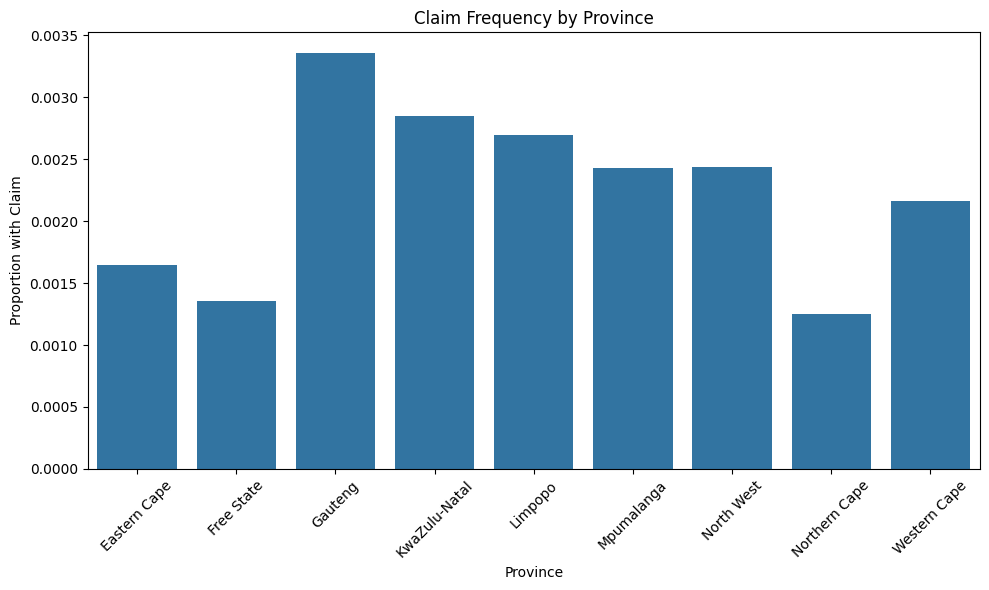

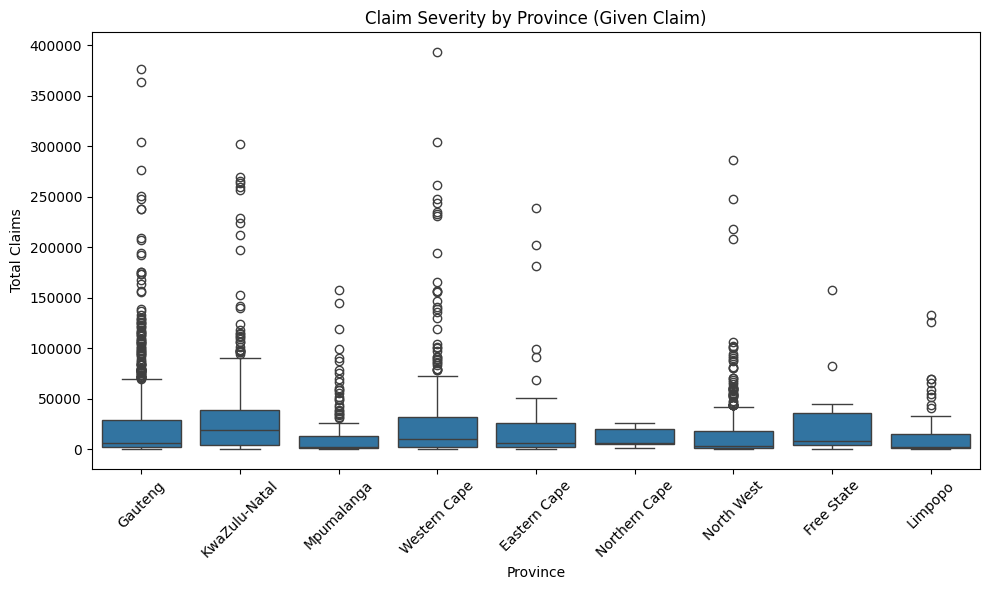

In [39]:
# -----------------------------
# PROVINCE-BASED RISK ANALYSIS
# -----------------------------

province_counts = df.groupby("Province")["PolicyID"].count()
claims_by_province = df.groupby("Province")["TotalClaims"].sum()
has_claim_by_province = df.groupby("Province")["TotalClaims"].apply(lambda x: (x > 0).sum())

# Z-test between Gauteng and Western Cape
province_a = "Gauteng"
province_b = "Western Cape"
count = np.array([has_claim_by_province.get(province_a, 0), has_claim_by_province.get(province_b, 0)])
nobs = np.array([province_counts.get(province_a, 0), province_counts.get(province_b, 0)])
z_stat, p_province = proportions_ztest(count, nobs)

print("Null Hypothesis (H₀): There are no risk differences across provinces.")
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.5f}")
print("→", "Reject H₀" if p_val < 0.05 else "Fail to reject H₀")

# Claim Frequency Plot for Provinces
plt.figure(figsize=(10, 6))
sns.barplot(x=province_counts.index, y=has_claim_by_province / province_counts)
plt.title("Claim Frequency by Province")
plt.ylabel("Proportion with Claim")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Severity Boxplot for Provinces
df_province_claims = df[df["TotalClaims"] > 0]
plt.figure(figsize=(10, 6))
sns.boxplot(x="Province", y="TotalClaims", data=df_province_claims)
plt.title("Claim Severity by Province (Given Claim)")
plt.ylabel("Total Claims")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# End of recent edits

ANOVA F-statistic: 0.9022
p-value: 0.98102
→ Fail to reject H₀


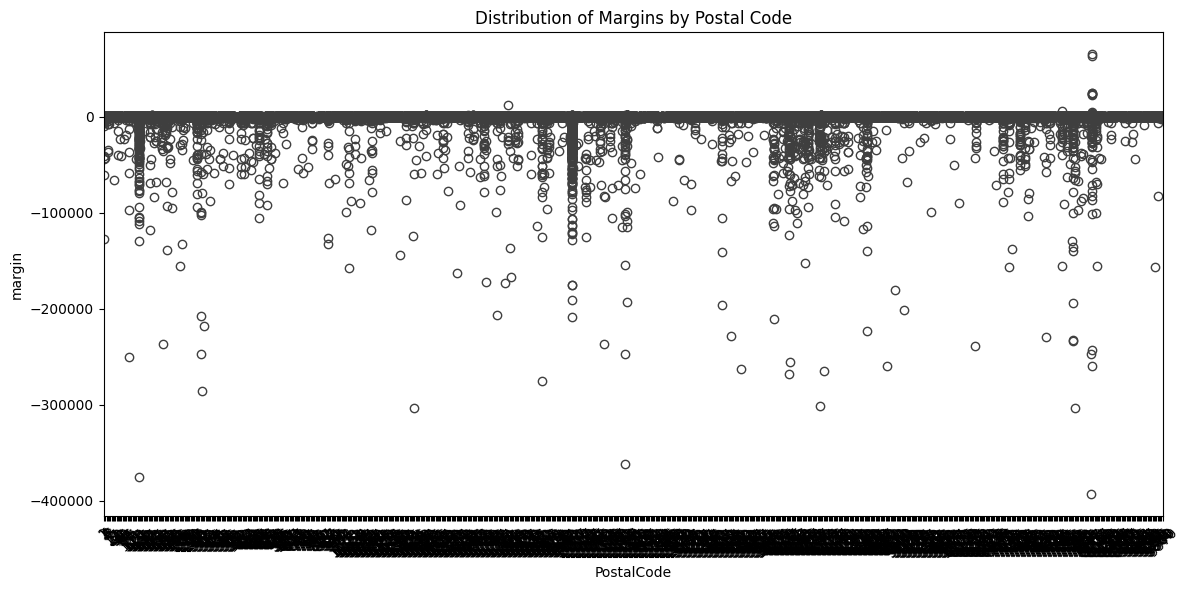

In [41]:


mean_margin_by_zip = df.groupby("PostalCode")["margin"].mean()
zip_counts = df.groupby("PostalCode")["margin"].count()
valid_zips = zip_counts[zip_counts >= 5].index

# Prepare list of margin arrays for each valid postal code
margin_groups = [df[df["PostalCode"] == zip]["margin"] for zip in valid_zips]

# Perform ANOVA
if len(margin_groups) > 1:
    f_stat, p_val = f_oneway(*margin_groups)
    print(f"ANOVA F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_val:.5f}")
    print("→", "Reject H₀" if p_val < 0.05 else "Fail to reject H₀")
else:
    print("Not enough postal codes with sufficient data for ANOVA.")

# Plotting the distribution of margins by postal code
plt.figure(figsize=(12, 6)) 
sns.boxplot(x="PostalCode", y="margin", data=df[df["PostalCode"].isin(valid_zips)])
plt.title("Distribution of Margins by Postal Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
